This script computes a score between 0 and 1 that indicates how similar the departments of an author entity are to the departments of an abbreviation entity. The score is computed by comparing the two department arrays with the wasserstein distance and penalizing the score by the percentage of departments that are not in both arrays. The score is normalized by the maximum wasserstein distance and the maximum penalization score. The score is closer to 0 if the two department arrays are identical and 1 if they are completely different.

In [1]:
import json
import sqlite3

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
from scipy.stats import wasserstein_distance

from src.models.MatchingType import MatchingType
from src.utils.author_mapping.determine_department_entity_shares import determine_departments_abbreviation_and_full_name_shares


In [2]:
DEPARTMENT_THRESHOLD = 10
PENALIZATION_SCORE_SCALAR = 1
SMALL_DEPARTMENT_NUMBER_PENALTY_Y_INTERSECT = 0.2
SMALL_DEPARTMENT_NUMBER_PENALTY_SLOPE = -0.05

## Fetch and prepare the data

In [3]:
con = sqlite3.connect('../data/interim/articles_with_author_mapping.db')
cur = con.cursor()

In [34]:
# get all articles with affiliated authors that are not organizations
rows = cur.execute("SELECT ar.id, ar.article_namespace_array, ar.published_at, a.name, a.abbreviation, a.matching_type FROM articles ar join unmapped_article_authors aa on ar.id = aa.article_id join unmapped_authors a on aa.author_id = a.id where a.matching_type != ?", (MatchingType.ORGANIZATION_MATCH.name, )).fetchall()

In [35]:
department_affiliation = pd.DataFrame(columns=['id', 'department', 'published_at', 'name', 'abbreviation', 'matching_type'], data=rows)

In [36]:
# get names where matching_type is only IS_FULL_NAME and never has another value
not_matched_authors = department_affiliation.groupby('name').filter(
    lambda x: all(match_type == MatchingType.IS_FULL_NAME for match_type in x['matching_type'].values))

# remove rows where name in names_with_only_full_name
department_affiliation = department_affiliation[~department_affiliation["name"].isin(not_matched_authors["name"].tolist())]

In [37]:
department_affiliation["department"] = department_affiliation["department"].apply(lambda x: json.loads(x))
department_affiliation = department_affiliation.explode('department')

In [38]:
department_affiliation

,id,department,published_at,name,abbreviation,matching_type
0,1504,Region,2021-12-10T06:22:00+00:00,Mathias Schönknecht,None,IS_FULL_NAME
0,1504,Delitzsch,2021-12-10T06:22:00+00:00,Mathias Schönknecht,None,IS_FULL_NAME
1,1505,Region,2021-12-10T05:27:19+00:00,Kay Würker,None,IS_FULL_NAME
1,1505,Altenburg,2021-12-10T05:27:19+00:00,Kay Würker,None,IS_FULL_NAME
2,1507,Leipzig,2021-12-10T06:01:00+00:00,Andreas Dunte,None,IS_FULL_NAME
...,...,...,...,...,...,...
166024,367703,Markranstaedt,2010-01-01T17:14:06+00:00,Kendra Reinhardt,None,IS_FULL_NAME
166025,367705,Region,2010-01-01T17:32:16+00:00,Thomas Steingen,None,IS_FULL_NAME
166025,367705,Delitzsch,2010-01-01T17:32:16+00:00,Thomas Steingen,None,IS_FULL_NAME
166027,367709,Leipzig,2010-01-01T22:35:30+00:00,Jens Rometsch,None,IS_FULL_NAME


In [39]:
# Get unique name, abbreviation pairs where abbreviation or name is not nan
name_abbreviation_dict = department_affiliation[(~department_affiliation["name"].isna()) & (~department_affiliation["abbreviation"].isna())][["name", "abbreviation"]].drop_duplicates().values.tolist()

## Clean the data

In [40]:
# remove rows where department equals "Region" or "Nachrichten" for being to unspecific
department_affiliation = department_affiliation[department_affiliation.department != 'Region']
department_affiliation = department_affiliation[department_affiliation.department != 'Nachrichten']

In [41]:
# set name to None in rows that where matched to prevent from names being matched to articles where the abbreviation is connected to but not the name (e.g. prevent like we are before the proximity matching)
department_affiliation.loc[~department_affiliation["abbreviation"].isna(), "name"] = None

## Calculate the score

In [49]:
results = pd.DataFrame(columns=['name', 'abbreviation', 'wasserstein_distance', 'n_departments', 'n_not_overlapping_departments', 'penalization_score', 'score'])

In [50]:
def scale_department_count(department_count: pd.DataFrame, departments_scaler_score: pd.DataFrame, key) -> pd.DataFrame:
    # apply the scaling to each row
    department_count["count"] = department_count.apply(lambda x: scale_function(x, departments_scaler_score, key), axis=1)

    return department_count

def scale_function(row, departments_scaler_score, share_key):
    # Note: does not scale if department name is not in departments_scaler_score

    return int(row["count"] * 0.5/departments_scaler_score[departments_scaler_score["department"] == row["department"]][share_key].values[0]) if row["department"] in departments_scaler_score["department"].tolist() else row["count"]


In [51]:
departments_scaler_score = determine_departments_abbreviation_and_full_name_shares(cur)

# Iterate over all names and their abbreviations and fill the results dataframe
for name, abbr in tqdm.tqdm(name_abbreviation_dict):
    
    departments_filtered_for_name = department_affiliation[(department_affiliation["name"] == name)]
    name_department_count = departments_filtered_for_name.groupby(['name', 'department']).size().reset_index(name='count').sort_values(['name', 'count'], ascending=[True, False])
    
    departments_filtered_for_abbr = department_affiliation[(department_affiliation["abbreviation"] == abbr)]
    abbr_department_count = departments_filtered_for_abbr.groupby(['abbreviation', 'department']).size().reset_index(name='count').sort_values(['abbreviation', 'count'], ascending=[True, False])
    
    # scale the article count up or down depending on the full_name/abbreviation share of the department
    #abbr_department_count = scale_department_count(abbr_department_count, departments_scaler_score, "abbreviation_share")
    #name_department_count = scale_department_count(name_department_count, departments_scaler_score, "full_name_share")

    # remove departments with less than 10 articles to get rid of noise
    # Note: this might result in a department not being in both lists anymore because it had less than 10 articles for one of the two entities (e.g. increasing the penalty)
    name_department_count = name_department_count[name_department_count["count"] >= DEPARTMENT_THRESHOLD]
    abbr_department_count = abbr_department_count[abbr_department_count["count"] >= DEPARTMENT_THRESHOLD]
    
    # get number of departments that for the author entity
    n_departments_for_author = len(set(name_department_count["department"].tolist() + abbr_department_count["department"].tolist()))
    
    # get number of departments that are not in both lists (needed for penalization later)
    n_not_overlapping_departments = len(set(name_department_count["department"].tolist()) ^ set(abbr_department_count["department"].tolist()))
    
    # remove departments that are not in both lists
    name_department_count = name_department_count[name_department_count["department"].isin(abbr_department_count["department"].tolist())]
    abbr_department_count = abbr_department_count[abbr_department_count["department"].isin(name_department_count["department"].tolist())]
    
    # create lists of the departments for each entity
    name_department_list = name_department_count["department"].tolist()
    abbr_department_list = abbr_department_count["department"].tolist()
    
    # order the two dataframes by the same order of departments
    categorical = pd.Categorical(name_department_count["department"], categories=name_department_count["department"].tolist())
    abbr_department_count = abbr_department_count.set_index("department").reindex(categorical).reset_index()
    
    # get counts into a list each
    name_department_count_list = name_department_count["count"].tolist()
    abbr_department_count_list = abbr_department_count["count"].tolist()
    
    # if the two lists do not have any overlap, set the distance to one (worst case) as it is the same for the worst normalized score
    # test if any element in abbr_department_count_list is in full_name_department_count_list
    if not any(elem in name_department_list for elem in abbr_department_list):
        score = 1
        # add to results with loc
        results.loc[len(results)] = [name, abbr, np.nan, n_departments_for_author, n_not_overlapping_departments, np.nan, 1]
        continue
        
    # compare with wasserstein metric
    w_distance = wasserstein_distance(range(0, len(name_department_count_list)), range(0, len(abbr_department_count_list)), name_department_count_list, abbr_department_count_list)
    
    # calculate penalization score
    # construct linear function that penalizes the difference in department arrays
    # it computes the score be taking the percentage of not overlapping departments 
    # it gets scaled by a factor alpha
    small_department_number_penalty = max(0, SMALL_DEPARTMENT_NUMBER_PENALTY_Y_INTERSECT + (SMALL_DEPARTMENT_NUMBER_PENALTY_SLOPE * n_departments_for_author))  # add a small penalty for small numbers of departments
    penalization_score = PENALIZATION_SCORE_SCALAR * (n_not_overlapping_departments / n_departments_for_author + small_department_number_penalty)
    
    # fill score later after normalization of both wasserstein distance and penalization score
    score = np.nan
        
    # add to results
    results.loc[len(results)] = [name, abbr, w_distance, n_departments_for_author, n_not_overlapping_departments, penalization_score, score]
    

100%|██████████| 1/1 [00:00<00:00, 37.36it/s]


In [45]:
# normalize wasserstein distance
results["wasserstein_distance_normalized"] = (results["wasserstein_distance"] - results["wasserstein_distance"].min()) / (results["wasserstein_distance"].max() - results["wasserstein_distance"].min())

# normalize penalization score
results["penalization_score_normalized"] = (results["penalization_score"] - results["penalization_score"].min()) / (results["penalization_score"].max() - results["penalization_score"].min())  

# compute score for rows where it is not set to 1
results.loc[results["score"].isna(), "score"] = 1/2 * (results["wasserstein_distance_normalized"] + results["penalization_score_normalized"])

In [46]:
results

,name,abbreviation,wasserstein_distance,n_departments,n_not_overlapping_departments,penalization_score,score,wasserstein_distance_normalized,penalization_score_normalized
0,Julia Tonne,jto,0.000000,7,6,0.857143,0.451128,0.000000,0.902256
1,Ekkehard Schulreich,es,0.270415,5,1,0.200000,0.146063,0.081600,0.210526
2,André Neumann,an,0.000000,3,2,0.716667,0.377193,0.000000,0.754386
3,Roger Dietze,red,0.000000,12,11,0.916667,0.482456,0.000000,0.964912
4,Janina Fleischer,jaf,0.063181,4,2,0.500000,0.272691,0.019065,0.526316
...,...,...,...,...,...,...,...,...,...
270,Jens Rometsch,joh,0.000000,11,9,0.818182,0.430622,0.000000,0.861244
271,Kendra Reinhardt,ka,NaN,5,5,NaN,1.000000,NaN,NaN
272,Nadja Topfstedt,jap,NaN,2,2,NaN,1.000000,NaN,NaN
273,Stefan Banitz,stb,0.128161,7,1,0.142857,0.094525,0.038674,0.150376


## Visualizations that should be moved into another notebook

For this, manipulate the name_abbreviation_dict to only contain the entities that should be visualized and re-run the cells above. Note that the normalization then does not have any effect anymore.

In [47]:
full_name = ("Matthias Puppe")
abbreviation = "mpu"
name_abbreviation_dict = [(full_name, abbreviation)]

In [48]:
# Note: run this directly after the running of the cells above with all the authors

viz_d_wasserstein = results[(results["name"] == full_name) & (results["abbreviation"] == abbreviation)]["wasserstein_distance"].tolist()[0]
viz_penalization_score = results[(results["name"] == full_name) & (results["abbreviation"] == abbreviation)]["penalization_score"].tolist()[0]
viz_score = results[(results["name"] == full_name) & (results["abbreviation"] == abbreviation)]["score"].tolist()[0]
viz_score

0.3139012233858309

In [52]:
viz_data = pd.DataFrame(columns=['author_entity', 'department', 'count', 'entity_type'])
# insert row for every row in name_department_list into viz_data with entity_type = "author" and name = full_name
for department in name_department_list[:10]:
    viz_data.loc[len(viz_data)] = [full_name, department, name_department_count[name_department_count["department"] == department]["count"].tolist()[0], "full name"]
# insert row for every row in abbr_department_list into viz_data with entity_type = "abbreviation" and name = abbreviation
for department in abbr_department_list[:10]:
    viz_data.loc[len(viz_data)] = [abbreviation, department, abbr_department_count[abbr_department_count["department"] == department]["count"].tolist()[0], "abbreviation"]


In [53]:
viz_data

,author_entity,department,count,entity_type
0,Matthias Puppe,Leipzig,726,full name
1,Matthias Puppe,Mitteldeutschland,656,full name
2,Matthias Puppe,Lokales,592,full name
3,Matthias Puppe,Polizeiticker,148,full name
4,Matthias Puppe,Sportbuzzer,110,full name
5,Matthias Puppe,Polizeiticker-Leipzig,109,full name
6,Matthias Puppe,Kultur,97,full name
7,Matthias Puppe,RB-Leipzig,44,full name
8,Matthias Puppe,RB-Archiv,34,full name
9,Matthias Puppe,Specials,34,full name


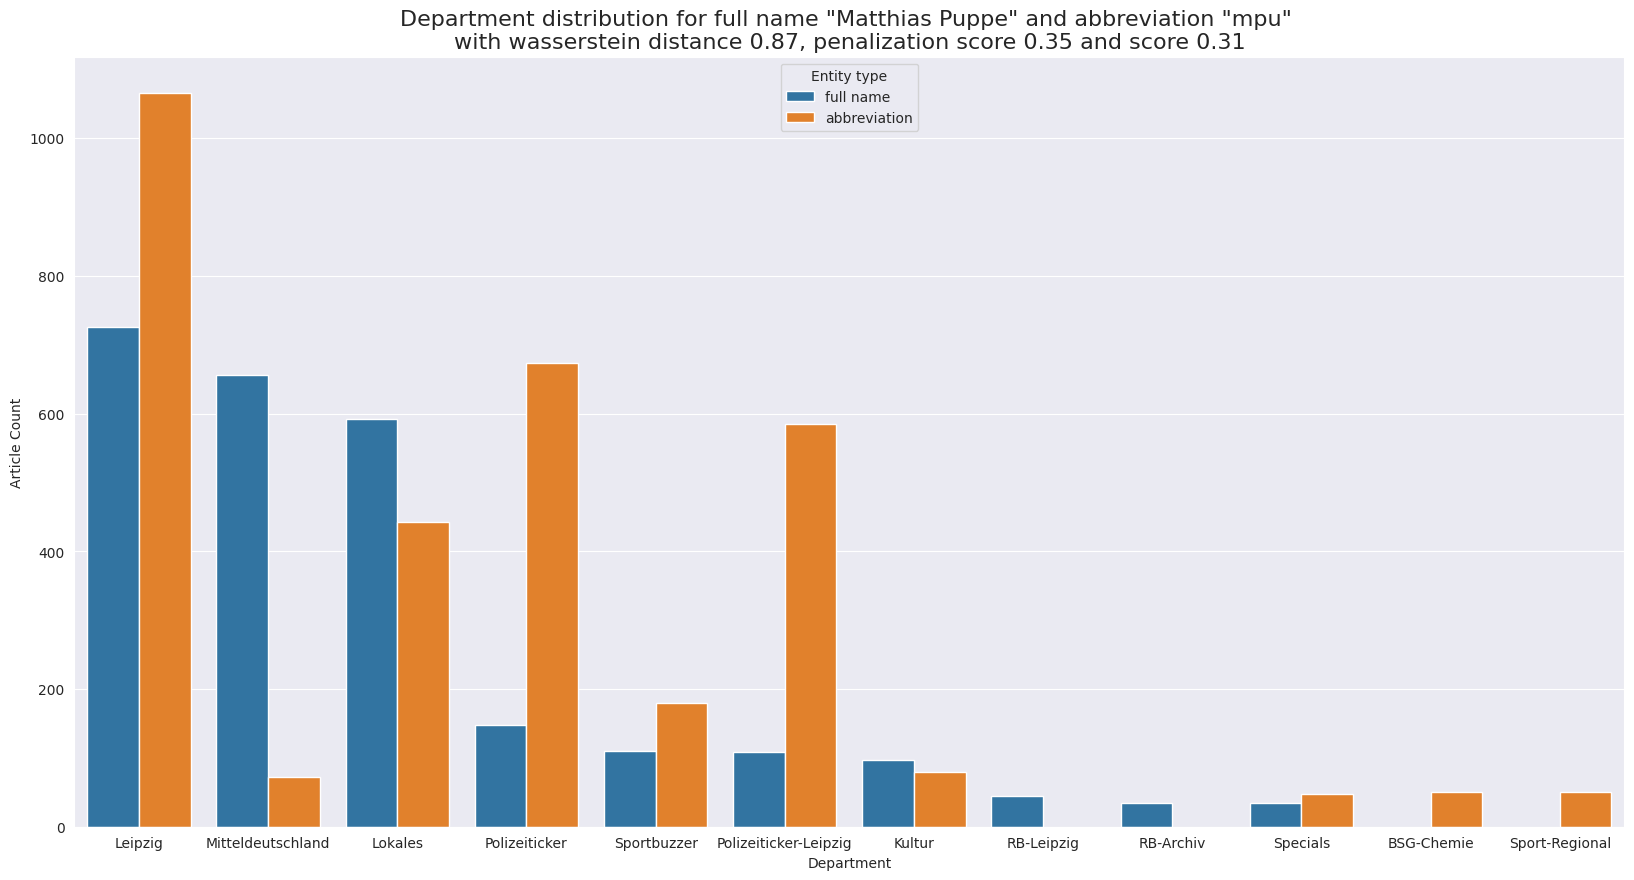

In [54]:
# increase figsize
plt.rcParams['figure.figsize'] = [20, 10]
sns.barplot(x="department", y="count", hue="entity_type", data=viz_data)
# set title
plt.title("Department distribution for full name \"" + full_name + "\" and abbreviation \"" + abbreviation + "\" \nwith wasserstein distance " + str(round(viz_d_wasserstein, 2)) + ", penalization score " + str(round(viz_penalization_score, 2)) + " and score " + str(round(viz_score, 2)), fontsize=16)

# set x label
plt.xlabel("Department")
# set y label
plt.ylabel("Article Count")
# set legend title
plt.legend(title="Entity type")
# save plot
# TODO: set with or without scaling when running this
plt.savefig("../reports/figures/department_exploration/department_distribution_" + full_name.replace(' ', '_').lower() + "_" + abbreviation.replace(' ', '_').lower() + "_without_department_scaling.png")
